### Построение и программная реализация алгоритма сплайн-интерполяции табличных функций

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src import points
from src import cubic_poly
from src import cubic_spline
from src import newton

Points = points.Points
CubicPolynome = cubic_poly.CubicPolynome
CubicSpline = cubic_spline.CubicSpline

newton_interpolate = newton.newton_interpolate
newton_2nd_deg = newton.newton_2nd_deg

In [2]:
table1: list[list[float]] = [
    [0, 0.5, 0.75, 1.25, 1.5, 2, 3, 4, 5, 6, 7],
    [0.250, 0.571, 0.842, 0.842, 0.571, 0.250, 0.077, 0.036, 0.020, 0.013, 0.009],
]

table2: list[list[float]] = [
    [-0.5, 0, 2, 3, 4],
    [-0.75, -1, 3, 8, 15],
    [-1, 0, 4, 6, 8],
]

table3: list[list[float]] = [
    [0, 0.25, 0.5, 0.75, 1],
    [1, 0.924, 0.707, 0.383, 0],
]

table = table1


pts = Points()
pts.parse_table(table)
target_x: float = 3.33

left_x = pts.data[0].x
right_x = pts.data[-1].x

left = newton_2nd_deg(pts, left_x)
right = newton_2nd_deg(pts, right_x)

xrange = np.linspace(left_x, right_x, 1000)

print("points:")
print(pts)
print()

print(f"target x: {target_x}")

points:
x:	0.000	0.500	0.750	1.250	1.500	2.000	3.000	4.000	5.000	6.000	7.000	
y:	0.250	0.571	0.842	0.842	0.571	0.250	0.077	0.036	0.020	0.013	0.009	

target x: 3.33


In [3]:
def plot_table():
    for pt in pts.data:
        plt.plot(pt.x, pt.y, "ro")

spline none:
0.05750241793835335


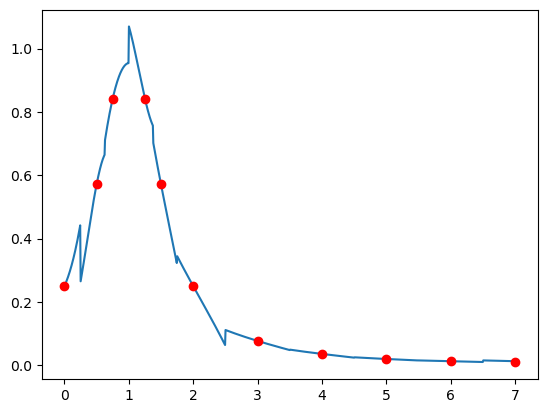

In [4]:
cs_none = CubicSpline()
print("spline none:")
print(cs_none.thomas(pts, target_x).get(target_x))

yrangelist = []
for x in xrange:
    yrangelist.append(cs_none.thomas(pts, x).get(x))

plt.plot(xrange, yrangelist)
plot_table()
plt.show()

spline left:
0.0574756115612994


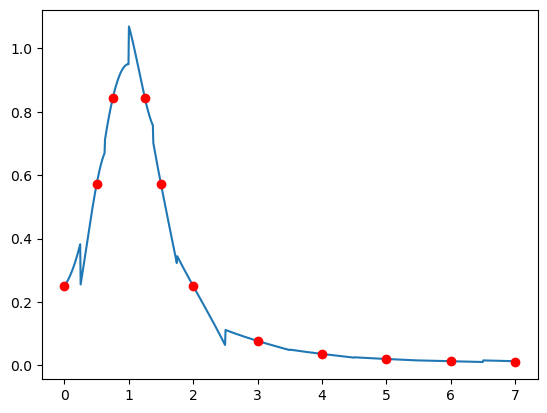

In [5]:
cs_left = CubicSpline(c_0=left)
print("spline left:")
print(cs_left.thomas(pts, target_x).get(target_x))

yrangelist = []
for x in xrange:
    yrangelist.append(cs_left.thomas(pts, x).get(x))

plt.plot(xrange, yrangelist)
plot_table()
plt.show()

spline both:
0.05747345787603183


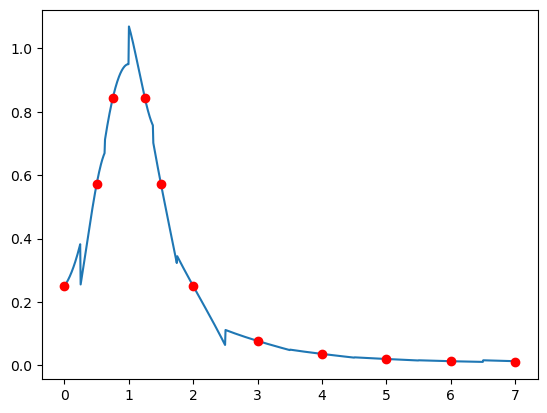

In [6]:
cs_all = CubicSpline(c_0=left, c_n=right)
print("spline both:")
print(cs_all.thomas(pts, target_x).get(target_x))

yrangelist = []
for x in xrange:
    yrangelist.append(cs_all.thomas(pts, x).get(x))

plt.plot(xrange, yrangelist)
plot_table()
plt.show()

newton:
0.06546325335000014


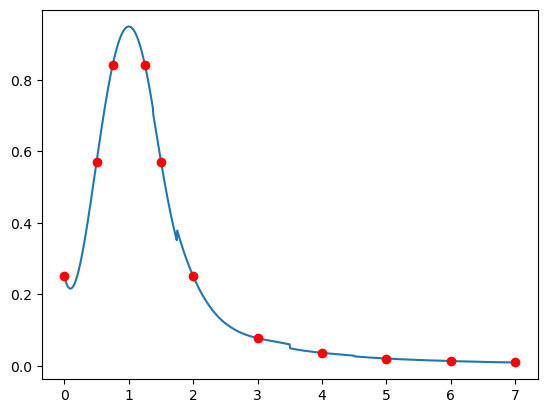

In [7]:
print("newton:")
print(newton_interpolate(target_x, min(4, len(pts.data)), pts))

yrangelist = []
for x in xrange:
    yrangelist.append(newton_interpolate(x, min(4, len(pts.data)), pts))

plt.cla()
plt.plot(xrange, yrangelist)
plot_table()
plt.show()